# Graph Neural Networks

### Loading Libraries

In [10]:
!pip install --upgrade pip
# !pip install yaml

In [18]:
# Installing the missing 'torchviz' library to resolve the error
!pip install torchviz

In [31]:
# Use pip to install the correct version of networkx
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.0 MB/s eta 0:00:00


In [33]:
# Numerical Computing
import numpy as np

# Data Manipulation
import polars as pl
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn
import sklearn
from sklearn.manifold import TSNE

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import dataset
from torchvision import datasets, transforms
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# PyTorch Geometry
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid

# Network
import networkx as nx

In [35]:
# Cuda's
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

In [37]:
torch.use_deterministic_algorithms(True)

### Helper Functions

In [39]:
def visualize(data, labels):
    tsne = TSNE(n_components=2, init='pca', random_state=7)
    tsne_res = tsne.fit_transform(data)
    v = pd.DataFrame(data,columns=[str(i) for i in range(data.shape[1])])
    v['color'] = labels
    v['label'] = v['color'].apply(lambda i: str(i))
    v["dim1"] = tsne_res[:,0]
    v["dim2"] = tsne_res[:,1]
    
    plt.figure(figsize=(12,12))

    sns.scatterplot(
        x="dim1", y="dim2",
        hue="color",
        palette=sns.color_palette(["#52D1DC", "#8D0004", "#845218","#563EAA", "#E44658", "#63C100", "#FF7800"]),
        legend=False,
        data=v,
    )

In [41]:
def visualize_graph(G, color):
    plt.figure(figsize=(75,75))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

## Loading Graph Dataset

In [43]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...
Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Done!


In [45]:
data = dataset[0]

### Graph Data Description

In [47]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


### Graph Visualization

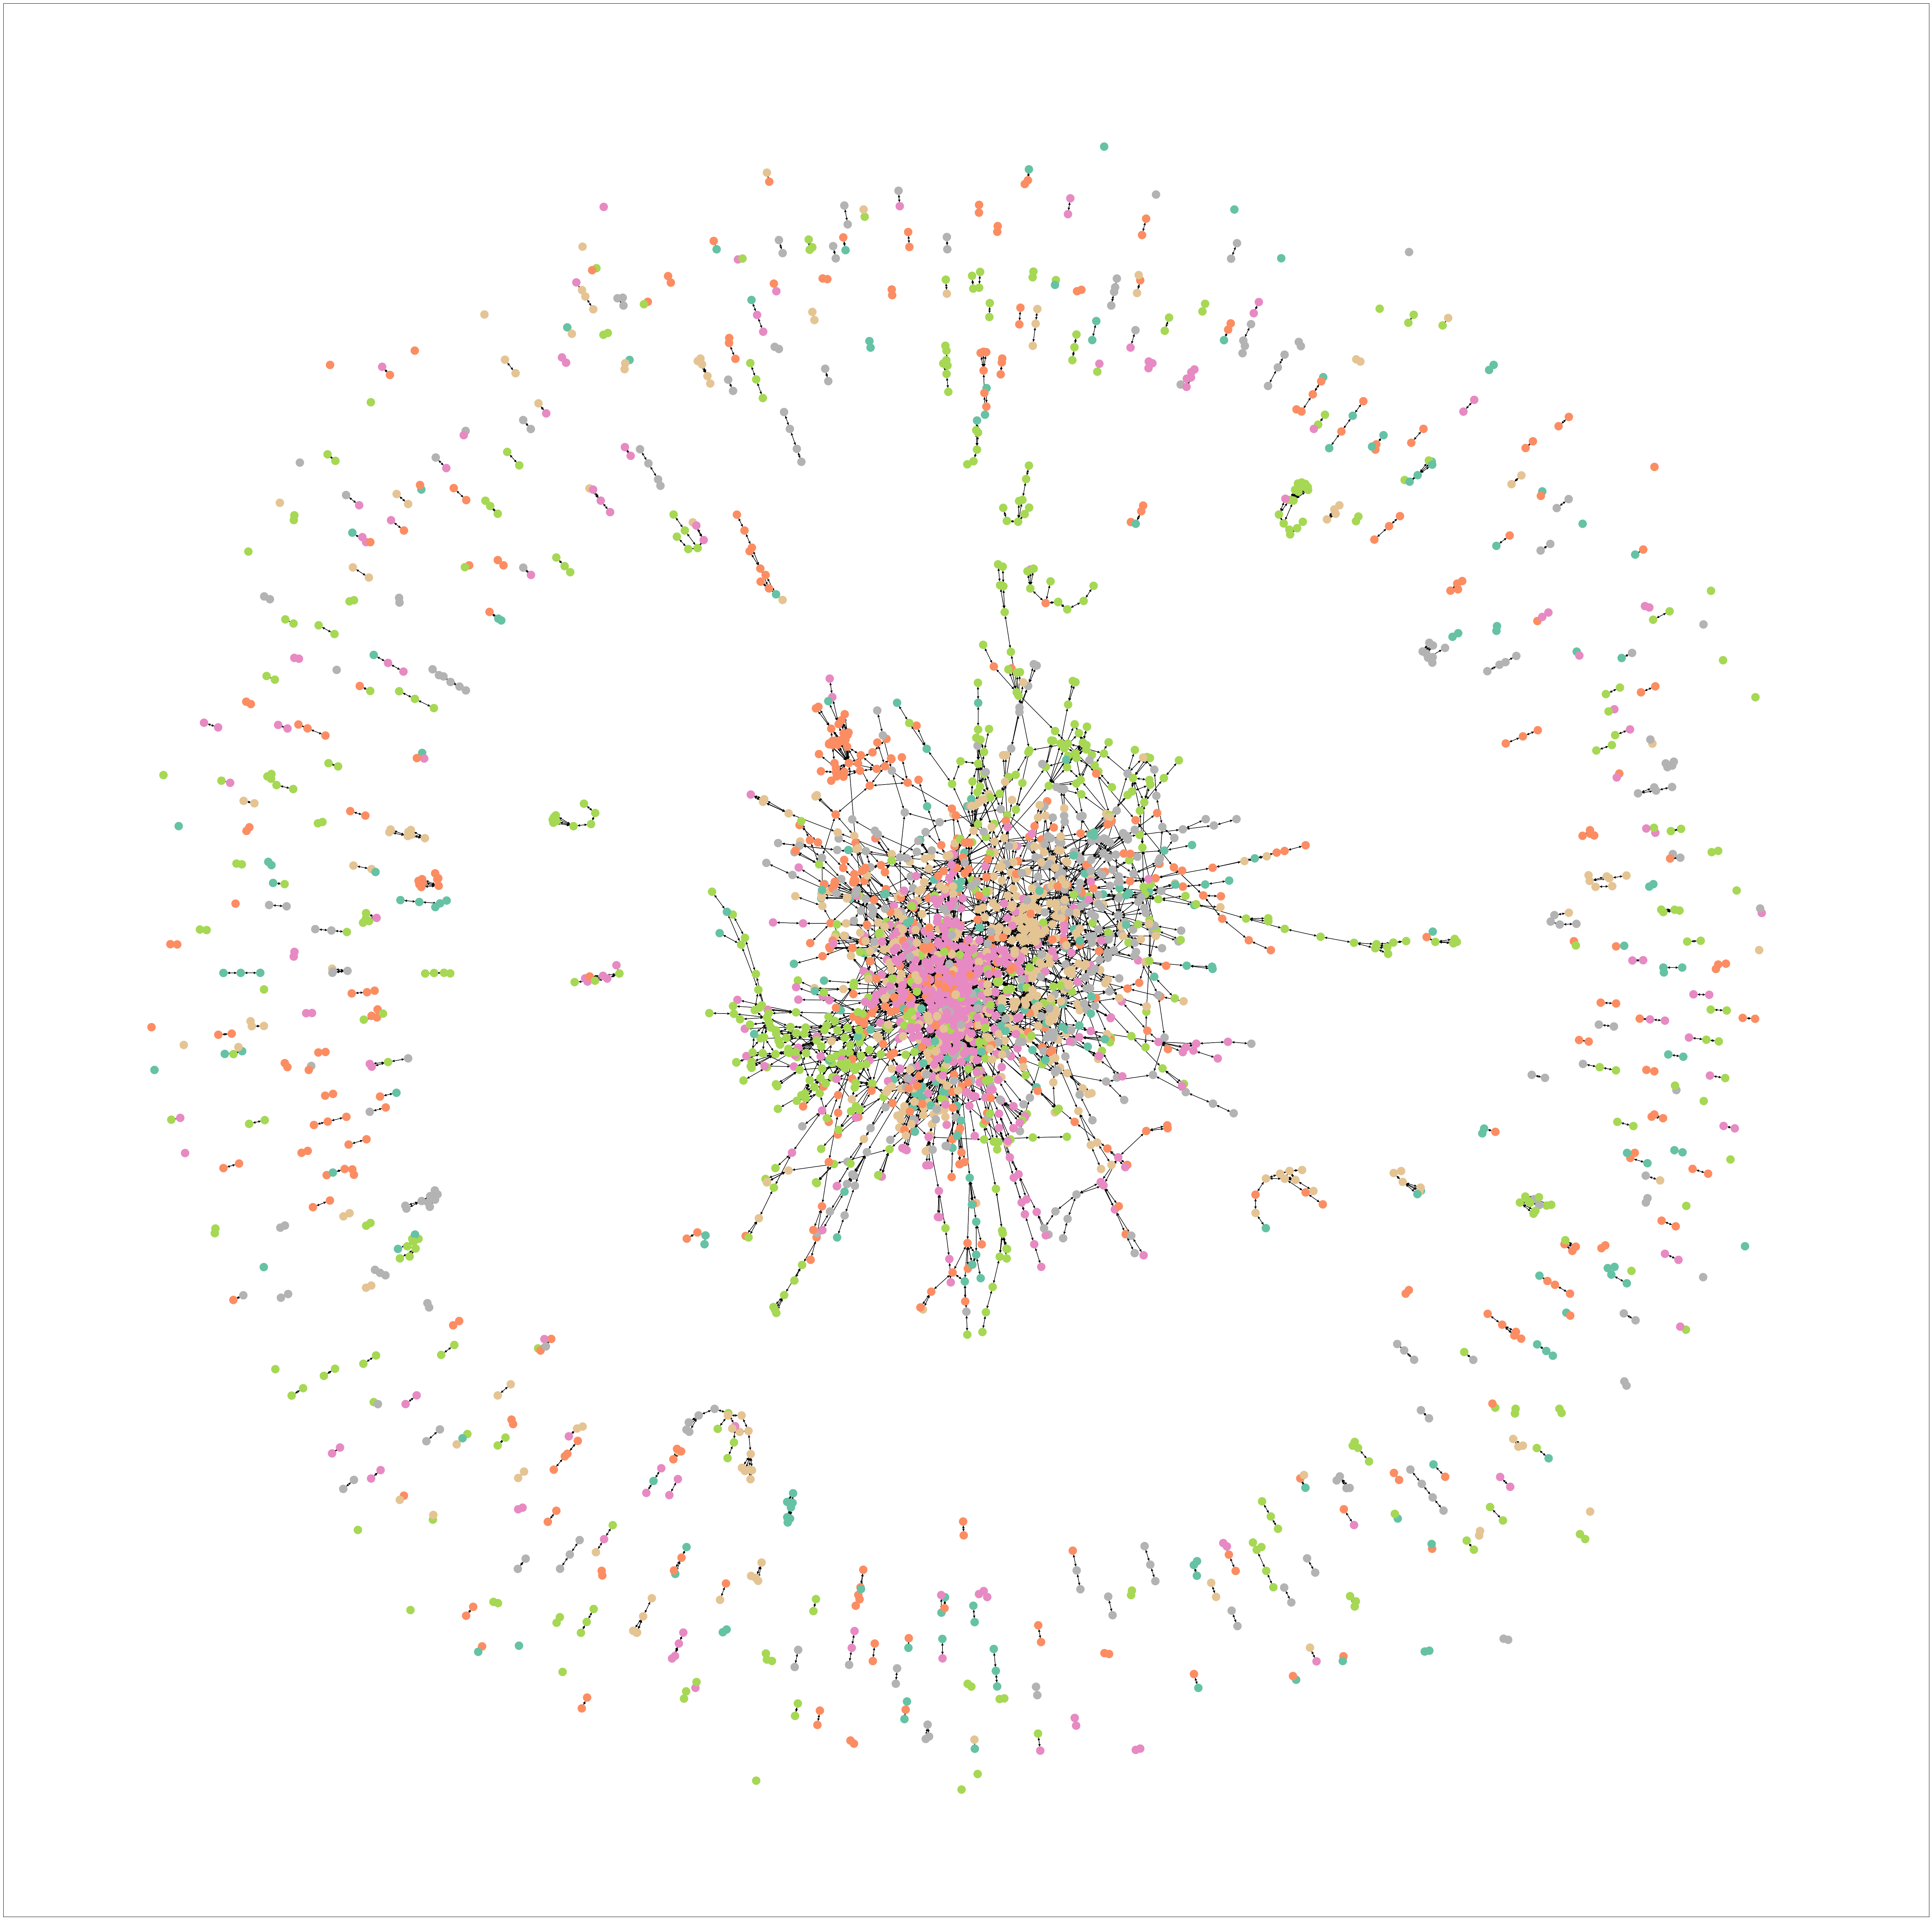

In [49]:
G = to_networkx(data)

visualize_graph(G, color=data.y)

## Graph model 1: Classic MLP

### Define and instantiate MLP model

In [53]:
from torch.nn import Linear

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)  # Ensure reproducibility
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


### Visualize Initial MLP Embeddings for Different Graph Nodes

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_55/2296163890.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


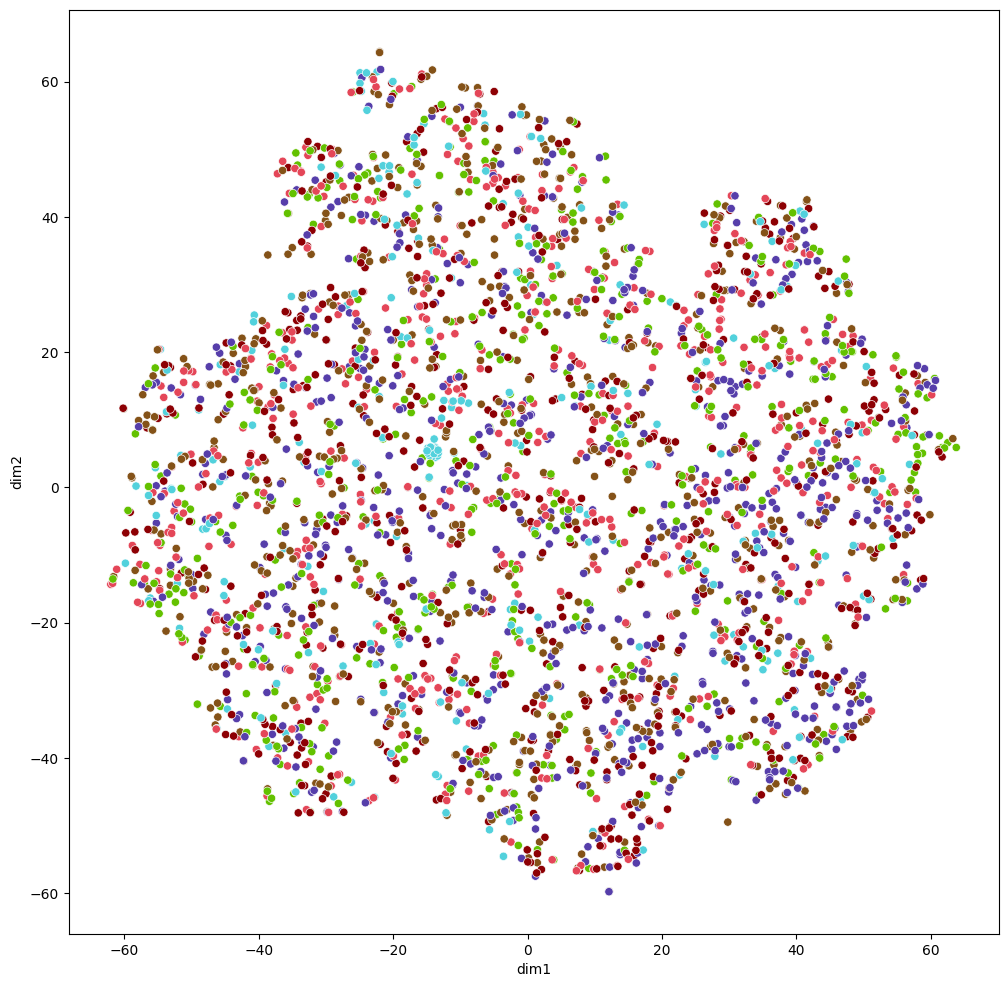

In [55]:
model.eval()
out = model(data.x)

visualize(out.detach().cpu().numpy(), data.y)

### Train MLP Model on Graph Dataset

In [57]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)  

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward()  
      optimizer.step()  
      return loss

def test(mask):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  
      correct = pred[mask] == data.y[mask]  
      acc = int(correct.sum()) / int(mask.sum())  
      return acc

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.8052, Val: 0.1020
Epoch: 002, Loss: 1.7371, Val: 0.1540
Epoch: 003, Loss: 1.6468, Val: 0.1940
Epoch: 004, Loss: 1.5291, Val: 0.2820
Epoch: 005, Loss: 1.3691, Val: 0.3720
Epoch: 006, Loss: 1.2793, Val: 0.4420
Epoch: 007, Loss: 1.0911, Val: 0.4760
Epoch: 008, Loss: 0.9573, Val: 0.5120
Epoch: 009, Loss: 0.8932, Val: 0.5180
Epoch: 010, Loss: 0.7698, Val: 0.5220
Epoch: 011, Loss: 0.6757, Val: 0.5300
Epoch: 012, Loss: 0.5749, Val: 0.5240
Epoch: 013, Loss: 0.5312, Val: 0.5260
Epoch: 014, Loss: 0.4824, Val: 0.5340
Epoch: 015, Loss: 0.4760, Val: 0.5300
Epoch: 016, Loss: 0.4488, Val: 0.5320
Epoch: 017, Loss: 0.3238, Val: 0.5260
Epoch: 018, Loss: 0.3813, Val: 0.5260
Epoch: 019, Loss: 0.3356, Val: 0.5260
Epoch: 020, Loss: 0.2751, Val: 0.5260
Epoch: 021, Loss: 0.3348, Val: 0.5360
Epoch: 022, Loss: 0.2972, Val: 0.5340
Epoch: 023, Loss: 0.2597, Val: 0.5300
Epoch: 024, Loss: 0.3105, Val: 0.5300
Epoch: 025, Loss: 0.2979, Val: 0.5300
Epoch: 026, Loss: 0.2541, Val: 0.5260
Epoch: 027, 

### Evaluate Model Performance on Test Set

In [59]:
test_acc = test(data.test_mask)

print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5710


### Visualize Trained Model's Embeddings for Different Graph Nodes

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_55/2296163890.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


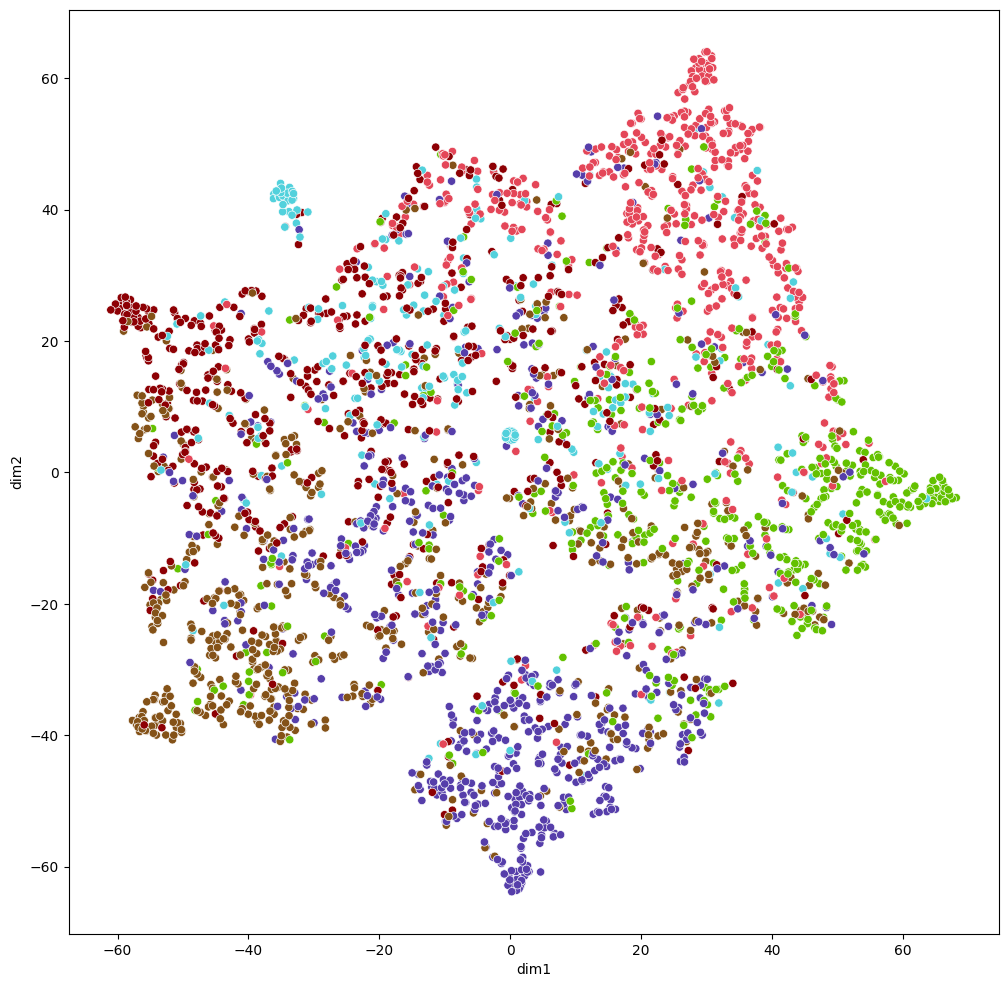

In [61]:
out = model(data.x)

visualize(out.detach().cpu().numpy(), data.y)

## Graph model 2: GCN

### Define & Instantiate GCN Model

In [63]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)


### Visualize Initial GCN Embeddings for Different Graph Nodes

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_55/2296163890.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


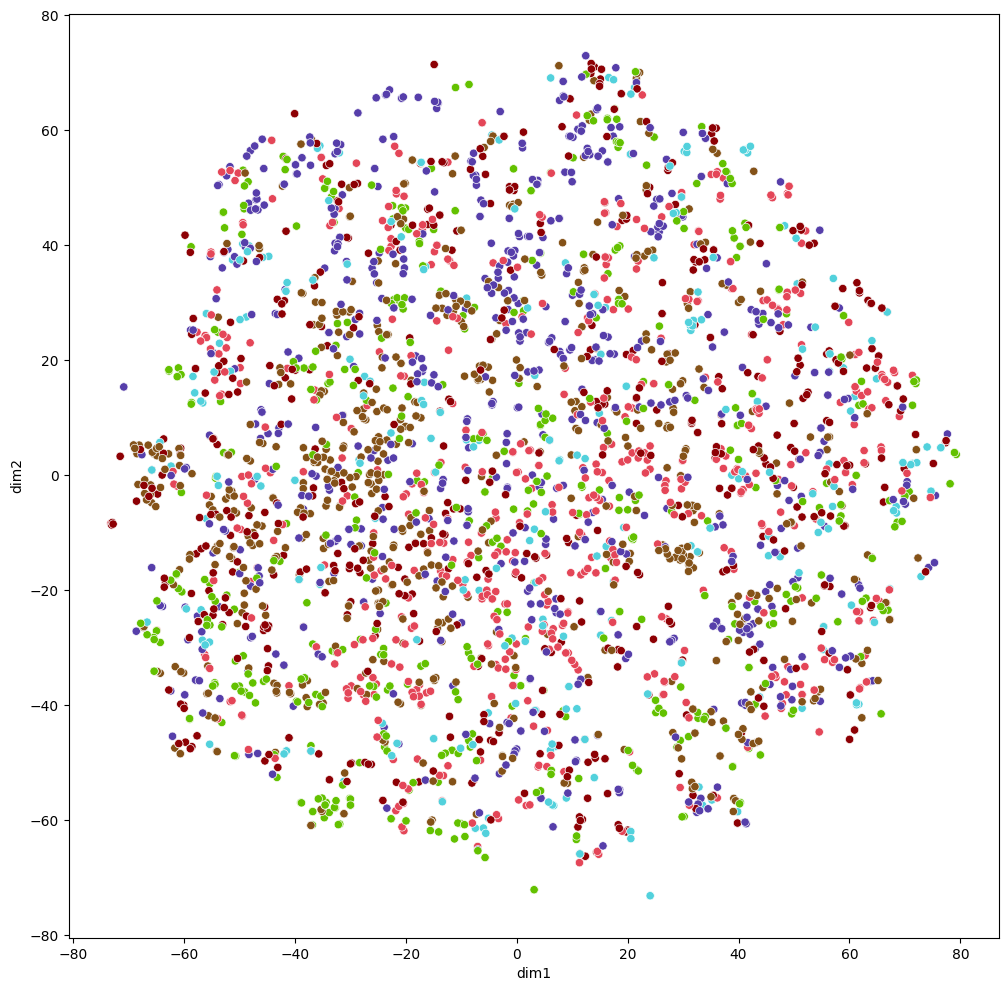

In [65]:
model = GCN(hidden_channels=32)
model.eval()

out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

### Trainingn GCN Model on Graph Dataset

In [67]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x, data.edge_index)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward()  
      optimizer.step()  
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  
      correct = pred[mask] == data.y[mask]  
      acc = int(correct.sum()) / int(mask.sum())  
      return acc


for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.7871, Val: 0.3620
Epoch: 002, Loss: 1.6260, Val: 0.4100
Epoch: 003, Loss: 1.4544, Val: 0.5100
Epoch: 004, Loss: 1.2277, Val: 0.5740
Epoch: 005, Loss: 1.0790, Val: 0.6200
Epoch: 006, Loss: 0.9047, Val: 0.6580
Epoch: 007, Loss: 0.7185, Val: 0.6840
Epoch: 008, Loss: 0.6246, Val: 0.6880
Epoch: 009, Loss: 0.5116, Val: 0.7020
Epoch: 010, Loss: 0.4641, Val: 0.7040
Epoch: 011, Loss: 0.4482, Val: 0.7060
Epoch: 012, Loss: 0.3567, Val: 0.7060
Epoch: 013, Loss: 0.2940, Val: 0.6960
Epoch: 014, Loss: 0.2789, Val: 0.6900
Epoch: 015, Loss: 0.2486, Val: 0.6880
Epoch: 016, Loss: 0.2356, Val: 0.6920
Epoch: 017, Loss: 0.2410, Val: 0.6980
Epoch: 018, Loss: 0.1904, Val: 0.6880
Epoch: 019, Loss: 0.2034, Val: 0.6880
Epoch: 020, Loss: 0.1713, Val: 0.6860
Epoch: 021, Loss: 0.1485, Val: 0.6840
Epoch: 022, Loss: 0.1872, Val: 0.6840
Epoch: 023, Loss: 0.1672, Val: 0.6880
Epoch: 024, Loss: 0.1606, Val: 0.6920
Epoch: 025, Loss: 0.1417, Val: 0.6880
Epoch: 026, Loss: 0.1766, Val: 0.6920
Epoch: 027, 

### Evaluate Model Performance on Test Set

In [69]:
test_acc = test(data.test_mask)

print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6960


### Visualize Trained Model's Embeddings for Different Graph Node

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_55/2296163890.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


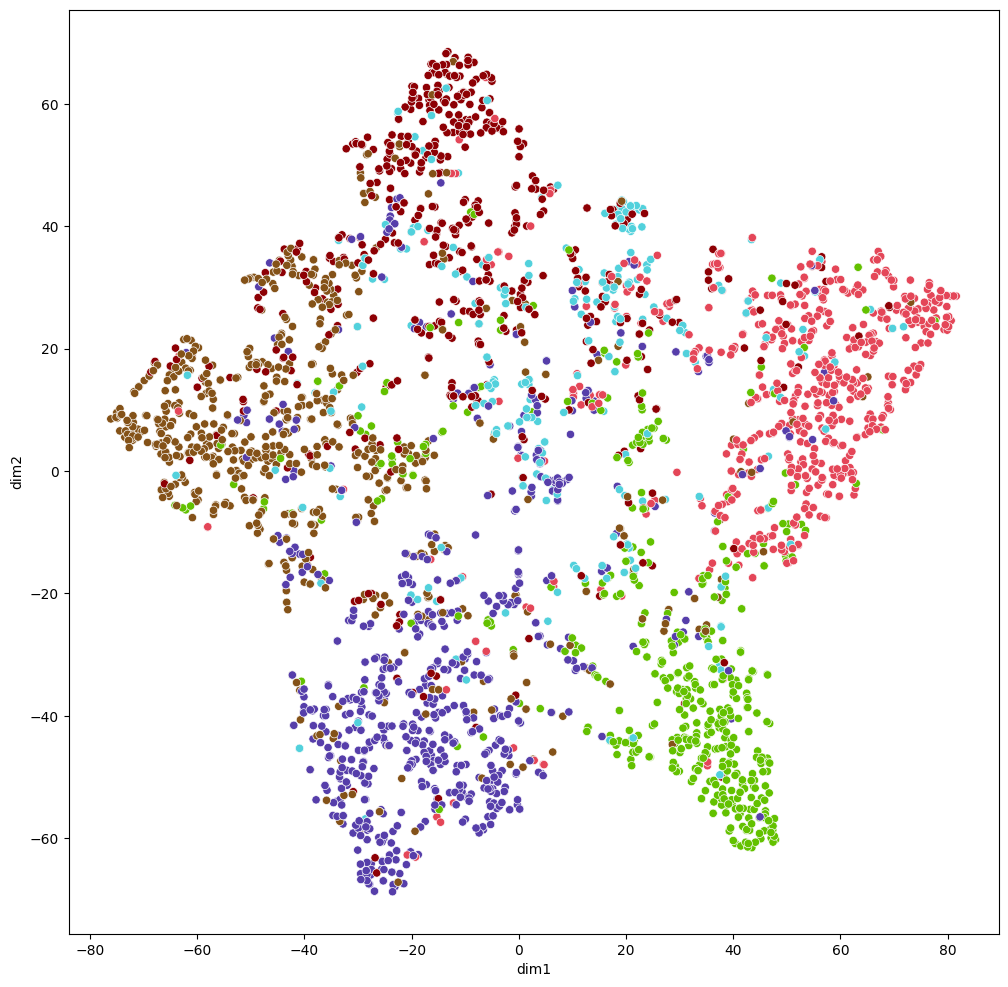

In [71]:
out = model(data.x, data.edge_index)

visualize(out.detach().cpu().numpy(), data.y)

## Graph Model 3: GAT

### Define & Instantiate GAT Model

In [73]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16, heads=8)
print(model)

GAT(
  (conv1): GATConv(3703, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


### Visualize Initial GAT Embeddings for Different Graph Nodes

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_55/2296163890.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


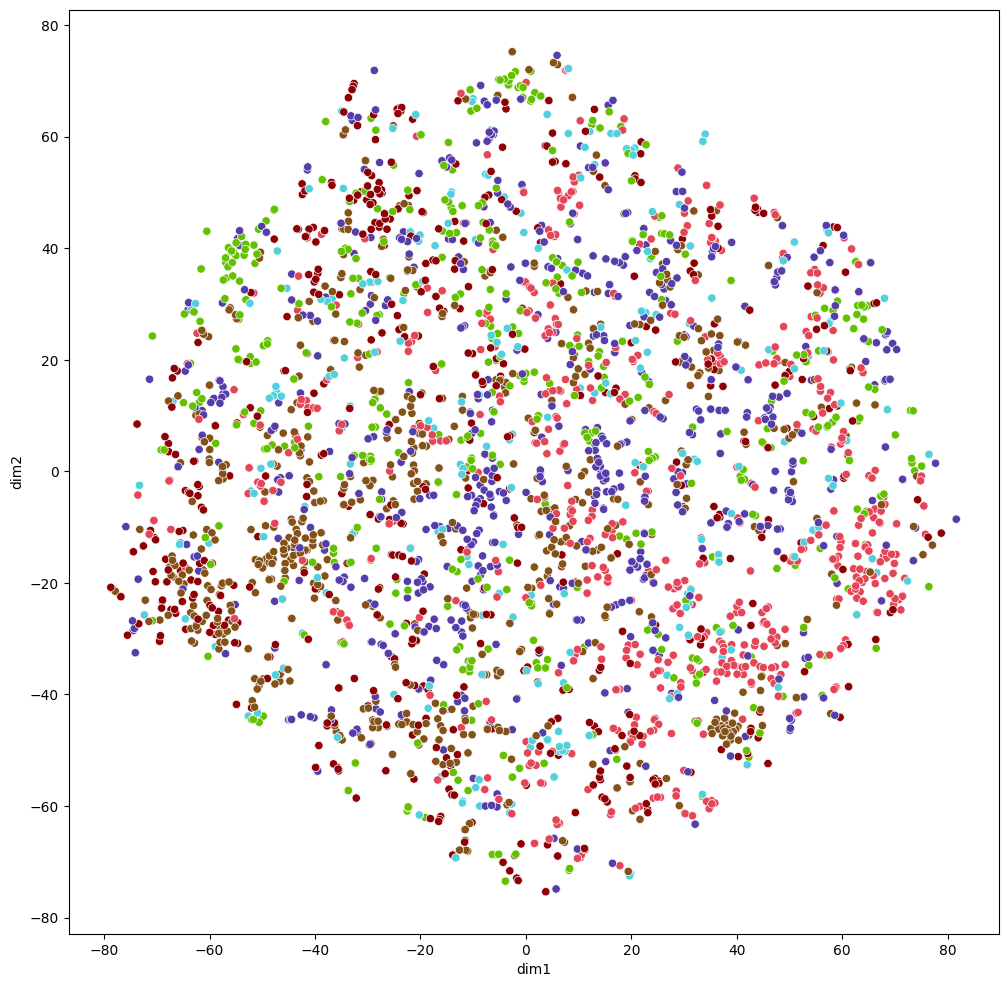

In [75]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

### Train GAT Model on Graph Dataset¶

In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-1)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x, data.edge_index)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward()  
      optimizer.step()  
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  
      correct = pred[mask] == data.y[mask]  
      acc = int(correct.sum()) / int(mask.sum())  
      return acc


for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.7799, Val: 0.2040
Epoch: 002, Loss: 1.7817, Val: 0.2320
Epoch: 003, Loss: 1.7773, Val: 0.2540
Epoch: 004, Loss: 1.7639, Val: 0.2800
Epoch: 005, Loss: 1.7721, Val: 0.3020
Epoch: 006, Loss: 1.7518, Val: 0.3380
Epoch: 007, Loss: 1.7545, Val: 0.3680
Epoch: 008, Loss: 1.7563, Val: 0.3940
Epoch: 009, Loss: 1.7319, Val: 0.4220
Epoch: 010, Loss: 1.7220, Val: 0.4500
Epoch: 011, Loss: 1.7230, Val: 0.4620
Epoch: 012, Loss: 1.7049, Val: 0.4860
Epoch: 013, Loss: 1.7074, Val: 0.5120
Epoch: 014, Loss: 1.6864, Val: 0.5260
Epoch: 015, Loss: 1.6896, Val: 0.5380
Epoch: 016, Loss: 1.6683, Val: 0.5460
Epoch: 017, Loss: 1.6577, Val: 0.5660
Epoch: 018, Loss: 1.6499, Val: 0.5720
Epoch: 019, Loss: 1.6514, Val: 0.5880
Epoch: 020, Loss: 1.6324, Val: 0.6000
Epoch: 021, Loss: 1.6355, Val: 0.6120
Epoch: 022, Loss: 1.6108, Val: 0.6220
Epoch: 023, Loss: 1.6031, Val: 0.6340
Epoch: 024, Loss: 1.6191, Val: 0.6440
Epoch: 025, Loss: 1.5901, Val: 0.6560
Epoch: 026, Loss: 1.5884, Val: 0.6600
Epoch: 027, 

### Evaluate Model Performance on Test Set

In [78]:
test_acc = test(data.test_mask)

print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7110


### Visualize Trained Model's Embeddings for Different Graph Nodes

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_55/2296163890.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


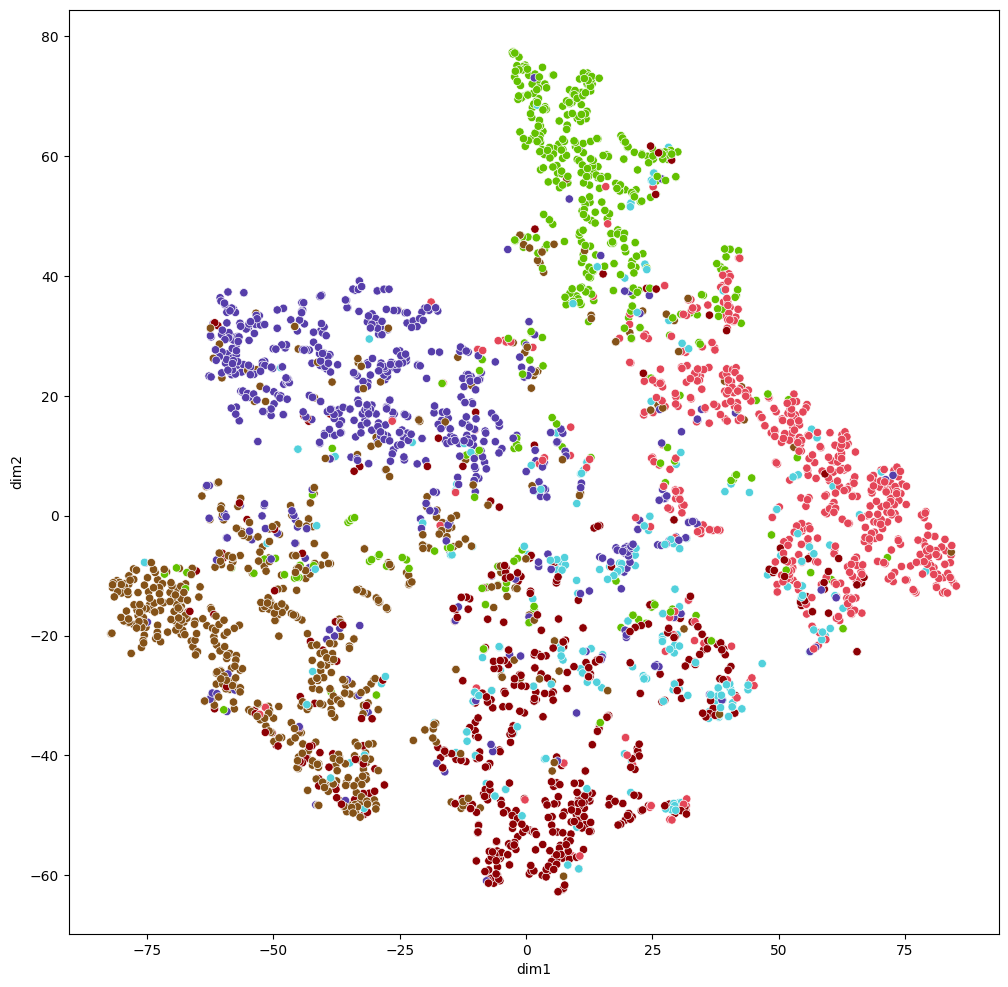

In [80]:
out = model(data.x, data.edge_index)

visualize(out.detach().cpu().numpy(), data.y)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c34d7e2-9616-4f95-b089-874ebeeb2d0c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>